In [1]:
import sys
import time
import random
from datetime import datetime

In [2]:
import numpy as np
import pandas as pd
import math

In [3]:
import matplotlib.pyplot as plt
import pydot

In [4]:
from keras import backend as K
import tensorflow as tf

***

In [5]:
# Genuine users and tweets
gen_users = pd.read_csv('dataset/users1.csv')
gen_tweets = pd.read_csv('dataset/tweets.csv')

In [6]:
def create_digital_dna_from_profile(users_df):
    df = users_df
    
    # Applying necessary replacements
    # 1 - Description is available, 0 - Description not available
    # 1 - URL is available, 0 - URL is not available
    df['description'] = np.where(pd.isnull(users_df['description']) == True, 0, 1)
    df['url'] = np.where(pd.isnull(users_df['url']) == True, 0, 1)
    
    # Changed user data
    return df

def create_digital_dna_from_tweets(tweets_df):
    '''For each user id in tweets_df return a digital DNA string based on posting behaviour.'''
    
    # Add columns for counts of tweets, replies and retweets.
    tweets_df['num_retweets'] = np.where(tweets_df['retweeted_status_id'] == 0, 0, 1)
    tweets_df['num_replies'] = np.where(tweets_df['in_reply_to_status_id'] == 0, 0, 1)
    tweets_df['num_tweets'] = np.where((tweets_df['num_retweets'] == 0) & (tweets_df['num_replies'] == 0), 1, 0)
    
    tweets = tweets_df['num_tweets'] == 1
    retweets = tweets_df['num_retweets'] == 1
    replies = tweets_df['num_replies'] == 1

    # DNA alphabet for tweet (A), retweet (C) and reply (T).
    tweets_df.loc[:, 'DNA'] = np.where(retweets, ' C', np.where(replies, ' T', ' A'))

    # Sort tweets by timestamp.
    tweets_df = tweets_df[['user_id', 'timestamp', 'DNA']]
    tweets_df = tweets_df.sort_values(by=['timestamp'])

    # Create digital DNA string for account.
    dna = tweets_df.groupby(by=['user_id'])['DNA'].agg(lambda x: ''.join(x))
    
    return dna

In [7]:
# Assigning float valeus in fields where necessary
def time_to_number(time_str):
    return np.float32(datetime.fromisoformat(time_str).timestamp())

def number_to_float(number):
    return np.float32(number)

def time_to_float(df, column_name):
    for index, value in enumerate(df[column_name]):
        df[column_name].at[index] = time_to_number(value)

def to_float(df, column_name):
    for index, value in enumerate(df[column_name]):
        df[column_name].at[index] = number_to_float(value)

In [8]:
to_float(gen_users, "statuses_count")
to_float(gen_users, "followers_count")
to_float(gen_users, "friends_count")
to_float(gen_users, "favourites_count")
to_float(gen_users, "listed_count")

time_to_float(gen_users, "timestamp")
time_to_float(gen_users, "updated")

In [9]:
print('Users shape:', gen_users.shape)
print('Tweets shape:', gen_tweets.shape)

Users shape: (3474, 42)
Tweets shape: (248533, 25)


***

# User Data - Section:

## Data Processing

In [10]:
# Filtering data which we need
twitter_account = gen_users.filter(["statuses_count", "followers_count",
                                    "friends_count", "favourites_count", "listed_count",
                                    "url", "description", "timestamp", "updated"])

In [11]:
# Processing user data and tweets of users
twitter_account = create_digital_dna_from_profile(twitter_account)
print('Users data shape:', twitter_account.shape)

Users data shape: (3474, 9)


## Processed Data

In [12]:
twitter_account

,statuses_count,followers_count,friends_count,favourites_count,listed_count,url,description,timestamp,updated
0,2177,208,332,265,1,0,1,1370938880.0,1458039168.0
1,2660,330,485,3972,5,0,1,1399966720.0,1458039168.0
2,1254,166,177,1185,0,0,1,1304541056.0,1458039168.0
3,202968,2248,981,60304,101,1,1,1284721280.0,1458039168.0
4,82,21,79,5,0,0,1,1423181440.0,1458039168.0
...,...,...,...,...,...,...,...,...,...
3469,315,94,597,36,4,0,0,1287564160.0,1458040320.0
3470,4099,5378,1238,471,6,1,1,1414135808.0,1458040320.0
3471,199,18,136,6,0,0,0,1421388032.0,1458040320.0
3472,2609,41,263,121,0,0,1,1268042368.0,1458040320.0


***

## Parameters

In [13]:
user_no_epochs        = 50
user_validation_split = 0.1

user_latent_dim       = 9

***

## Model

In [14]:
"""
Dropping tweets data because this model will be trianed just on the user data.
Converting all the other fields to float64 then giving it the shape for input.
The final variable contains the numpy array made from the dataframe.
"""
training_data              = twitter_account
training_data              = training_data.apply(pd.to_numeric)
training_data              = training_data.values.reshape(training_data.shape[0], training_data.shape[1])
features_in_feature_vector = training_data.shape[1]
input_shape                = (features_in_feature_vector, )

In [15]:
training_data      = training_data.T
mean               = np.mean(training_data, axis=0)
standard_deviation = np.std(training_data, axis=0)
training_data      = (training_data - mean) / standard_deviation
training_data = training_data.T

## Encoder

In [16]:
i       = tf.keras.layers.Input(shape=input_shape, name='encoder_input')
x       = tf.keras.layers.Dense(features_in_feature_vector, activation='relu')(i)
mu      = tf.keras.layers.Dense(1, name='latent_mu')(x)
sigma   = tf.keras.layers.Dense(1, name='latent_sigma')(x)

In [17]:
# Define sampling with reparameterization trick
def sample_z(args):
    mu, sigma = args
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

In [18]:
# Reparameterization for correct gradient
z = tf.keras.layers.Lambda(sample_z, output_shape=(1, ), name='z')([mu, sigma])

In [19]:
# Instantiate encoder
user_data = encoder = tf.keras.Model(i, [mu, sigma, z], name='encoder')
user_data.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 9)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 9)            90          encoder_input[0][0]              
__________________________________________________________________________________________________
latent_mu (Dense)               (None, 1)            10          dense[0][0]                      
__________________________________________________________________________________________________
latent_sigma (Dense)            (None, 1)            10          dense[0][0]                      
____________________________________________________________________________________________

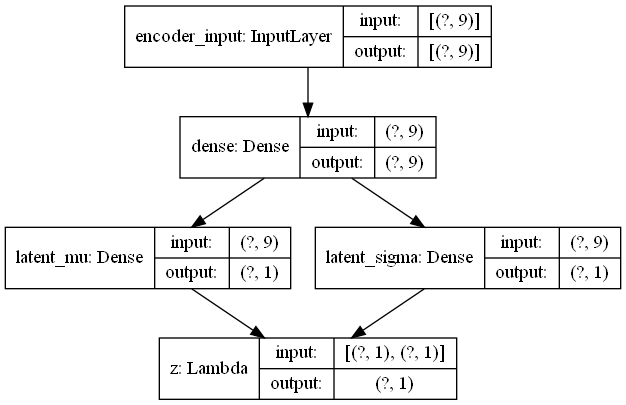

In [20]:
tf.keras.utils.plot_model(user_data, show_shapes=True)

## Decoder

In [21]:
d_i    = tf.keras.layers.Input(shape=(1, ), name='decoder_input')
x      = tf.keras.layers.Dense(3, activation='sigmoid')(d_i)
x      = tf.keras.layers.Dense(features_in_feature_vector, activation='sigmoid')(x)
o      = tf.keras.layers.Reshape(input_shape, name='decoder_output')(x)

In [22]:
# Instantiate decoder
decoder = tf.keras.Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 1)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 36        
_________________________________________________________________
decoder_output (Reshape)     (None, 9)                 0         
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


# VAE - User Data

In [23]:
# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = tf.keras.Model(i, vae_outputs, name='User_Data-VAE')
vae.summary()

Model: "User_Data-VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 9)]               0         
_________________________________________________________________
encoder (Functional)         [(None, 1), (None, 1), (N 110       
_________________________________________________________________
decoder (Functional)         (None, 9)                 42        
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________


## Loss Function

In [24]:
"""
KL Divergence metric this one which 
we are using loss function.
"""
user_data_kl_divergence_loss = tf.keras.losses.KLDivergence(reduction="auto", name="kl_divergence")

## Training

In [25]:
"""
We are using the adam optimizer from Keras in combination
of KL Divergence loss function also from Keras.
"""
vae.compile(optimizer='adam', loss=user_data_kl_divergence_loss, run_eagerly=True)

In [26]:
history = vae.fit(x = training_data, y = training_data, 
        epochs = user_no_epochs,
        shuffle=True,
        validation_split=user_validation_split,
        validation_data=training_data)

Epoch 1/50
98/98 [==============================] - 1s 11ms/step - loss: 0.9561 - val_loss: 0.7787
Epoch 2/50
98/98 [==============================] - 1s 10ms/step - loss: 0.6248 - val_loss: 0.4996
Epoch 3/50
98/98 [==============================] - 1s 10ms/step - loss: 0.4285 - val_loss: 0.3712
Epoch 4/50
98/98 [==============================] - 1s 10ms/step - loss: 0.3330 - val_loss: 0.2989
Epoch 5/50
98/98 [==============================] - 1s 10ms/step - loss: 0.2725 - val_loss: 0.2479
Epoch 6/50
98/98 [==============================] - 1s 10ms/step - loss: 0.2281 - val_loss: 0.2094
Epoch 7/50
98/98 [==============================] - 1s 10ms/step - loss: 0.1939 - val_loss: 0.1792
Epoch 8/50
98/98 [==============================] - 1s 10ms/step - loss: 0.1668 - val_loss: 0.1549
Epoch 9/50
98/98 [==============================] - 1s 10ms/step - loss: 0.1449 - val_loss: 0.1352
Epoch 10/50
98/98 [==============================] - 1s 11ms/step - loss: 0.1269 - val_loss: 0.1189
Epoch 11/

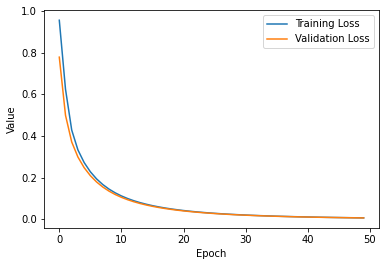

In [28]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()

In [29]:
def convert_to_data(data):
    return pd.DataFrame(data)

In [30]:
print('Original Data')
training_data = convert_to_data(training_data)
training_data

Original Data


,0,1,2,3,4,5,6,7,8
0,-0.534194,-0.534197,-0.534197,-0.534197,-0.534198,-0.534198,-0.534198,1.795677,1.943702
1,-0.534378,-0.534382,-0.534382,-0.534376,-0.534382,-0.534382,-0.534382,1.821470,1.919194
2,-0.533463,-0.533465,-0.533465,-0.533463,-0.533465,-0.533465,-0.533465,1.733742,2.000512
3,-0.532867,-0.533218,-0.533220,-0.533117,-0.533222,-0.533222,-0.533222,1.714432,2.017657
4,-0.534472,-0.534472,-0.534472,-0.534472,-0.534472,-0.534472,-0.534472,1.841555,1.899750
...,...,...,...,...,...,...,...,...,...
3469,-0.533202,-0.533203,-0.533202,-0.533203,-0.533203,-0.533203,-0.533203,1.717228,2.015190
3470,-0.534438,-0.534436,-0.534443,-0.534444,-0.534445,-0.534445,-0.534445,1.833785,1.907311
3471,-0.534467,-0.534467,-0.534467,-0.534467,-0.534467,-0.534467,-0.534467,1.840019,1.901248
3472,-0.532857,-0.532862,-0.532861,-0.532862,-0.532862,-0.532862,-0.532862,1.697891,2.032137


In [31]:
print('Predicted Data')
predicted_data = convert_to_data(vae.predict(training_data))
predicted_data

Predicted Data


,0,1,2,3,4,5,6,7,8
0,0.916604,0.915464,0.899127,0.873537,0.925908,0.919061,0.884905,0.997440,0.996154
1,0.916604,0.915424,0.899170,0.873528,0.925904,0.919079,0.884835,0.997439,0.996153
2,0.916604,0.915443,0.899149,0.873533,0.925906,0.919070,0.884869,0.997440,0.996154
3,0.916603,0.915484,0.899105,0.873542,0.925910,0.919051,0.884940,0.997441,0.996154
4,0.916600,0.915545,0.899035,0.873556,0.925914,0.919020,0.885050,0.997443,0.996154
...,...,...,...,...,...,...,...,...,...
3469,0.916604,0.915436,0.899156,0.873531,0.925906,0.919073,0.884857,0.997440,0.996154
3470,0.916604,0.915457,0.899135,0.873536,0.925908,0.919064,0.884892,0.997440,0.996154
3471,0.916598,0.915577,0.898997,0.873562,0.925916,0.919002,0.885108,0.997444,0.996154
3472,0.916604,0.915467,0.899123,0.873538,0.925909,0.919059,0.884911,0.997441,0.996154


In [32]:
"""
Graphs of original and reconstructed output
displayed for all of the feature vectors
individually.
"""
# for i in range(9):
#     plt.plot(training_data[i], color='blue')
#     plt.plot(predicted_data[i], color='red')
#     plt.xlabel('Index')
#     plt.ylabel('Value')
#     plt.figure(i)
#     plt.show()

'\nGraphs of original and reconstructed output\ndisplayed for all of the feature vectors\nindividually.\n'

***

# Tweets Section:

## Data Processing

In [33]:
tweets_dna = create_digital_dna_from_tweets(gen_tweets).to_numpy()
print('Tweets shape:', tweets_dna.shape)

Tweets shape: (100,)


## Term Vectors

In [34]:
"""
This part is being used to generate vocabulory which will be used to
convert the text into indices. Then this data can be converted to
matrices and fed to the learning models.
Sequence legth is set by checkcing the maximum lenth of string in the
dataset so that we don't have to lose any detail which help in
converting the representation back to the original text.
"""
VOCAB_SIZE = 5
MAX_SEQUENCE_LENGHT = 3500
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, output_sequence_length=MAX_SEQUENCE_LENGHT)
encoder.adapt(tweets_dna)

In [35]:
"""
Checking if the generated tokens are right which
will be used as terms for strigs.
"""
vocab = np.array(encoder.get_vocabulary())
print(vocab)

['' '[UNK]' 'a' 'c' 't']


In [36]:
"""
Checking if the original and the processed data
because presence of unknown chunks would make it
impossible to convert data back to text.
"""
encoded_example = encoder(tweets_dna)[:1].numpy()

for n in range(1):
    print("Original: ", tweets_dna[n])
    print("Processed: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:   A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A T A A A A A A T T A A A T A T A A A T A A A T A A T A T T A T T A A A A A A A A A A A A A A A A A A A A T A A A A A A T A A A A A A A A A A A A A A A A T A A T A T A A A A A A T A A A A A A A A A A A A A A A A A T A A T T A A A A A T T A A T T T A A A T A A A A A T A T A A A A A A A A A A T T A T A T T T A T A A A T A T A A A T A A A A A A A T A A A A A T T A A T A A A A T A A A A T A A A A T T A T T T T A T T T T A A A A T T A A A T A T T A T A A A A A T T A A A T T A A T T A T T T A T T A A T T A A T T T T T A T A A T T T A A T T A T T T T A A T T A A T A A T T T T T T A A A A T A T A T T A T A T T A A A A A A A T T T T A T A T A A T A A A A T T T T T T T T T T T T T T T T T T T A T A T T A T A T T T T T A T T A A A A T A A T T A A T A A T A A T A A A T A A A A A A T T A A A A A T T T A C A T C A A C A A A C T A T A C T C A T C T A T T A A A A A T A C T T C A A A C C A A C C C C A A T A A A T A A A A 

***

## Model

In [37]:
text_input_shape                 = (encoder(tweets_dna).shape[1], )
text_input_diensions             = len(encoder.get_vocabulary())
text_embedding_output_dimensions = 64

In [38]:
text_input_shape

(3500,)

## Encoder

In [39]:
encoder_input                 = tf.keras.layers.Input(shape=text_input_shape, name="TF_input", dtype='float32')
encoder_embedded              = tf.keras.layers.Embedding(input_dim=text_input_diensions, output_dim=64, mask_zero=True, name="Encoder_Embedding", dtype='float32')(encoder_input)
LTSM_layer, state_h, state_c  = tf.keras.layers.LSTM(64, return_state=True, name="LTSM", dtype='float32')(encoder_embedded)
dense_layer                   = tf.keras.layers.Dense(64, activation='relu', name="Compression", dtype='float32')(LTSM_layer)
final_layer                   = tf.keras.layers.Dense(1, activation='relu', name="Lossy_Compression", dtype='float32')(dense_layer)
text_mu                       = tf.keras.layers.Dense(1, name='latent_mu', dtype='float32')(final_layer)
text_sigma                    = tf.keras.layers.Dense(1, name='latent_sigma', dtype='float32')(final_layer)

In [40]:
text_encoder_states = [state_h, state_c]

In [41]:
# Define sampling with reparameterization trick
def sample_z(args):
    mu, sigma = args
    batch     = tf.keras.backend.shape(mu)[0]
    dim       = tf.keras.backend.int_shape(mu)[1]
    eps       = tf.keras.backend.random_normal(shape=(batch, dim))
    return text_mu + tf.keras.backend.exp(sigma / 2) * eps

text_z = tf.keras.layers.Lambda(sample_z, output_shape=(len(encoder.get_vocabulary()), ), name='z')([text_mu, text_sigma])

In [42]:
text_encoder = tf.keras.Model(encoder_input, [text_mu, text_sigma, text_z], name='TextCompressionModel')

In [43]:
text_encoder.summary()

Model: "TextCompressionModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TF_input (InputLayer)           [(None, 3500)]       0                                            
__________________________________________________________________________________________________
Encoder_Embedding (Embedding)   (None, 3500, 64)     320         TF_input[0][0]                   
__________________________________________________________________________________________________
LTSM (LSTM)                     [(None, 64), (None,  33024       Encoder_Embedding[0][0]          
__________________________________________________________________________________________________
Compression (Dense)             (None, 64)           4160        LTSM[0][0]                       
_______________________________________________________________________________

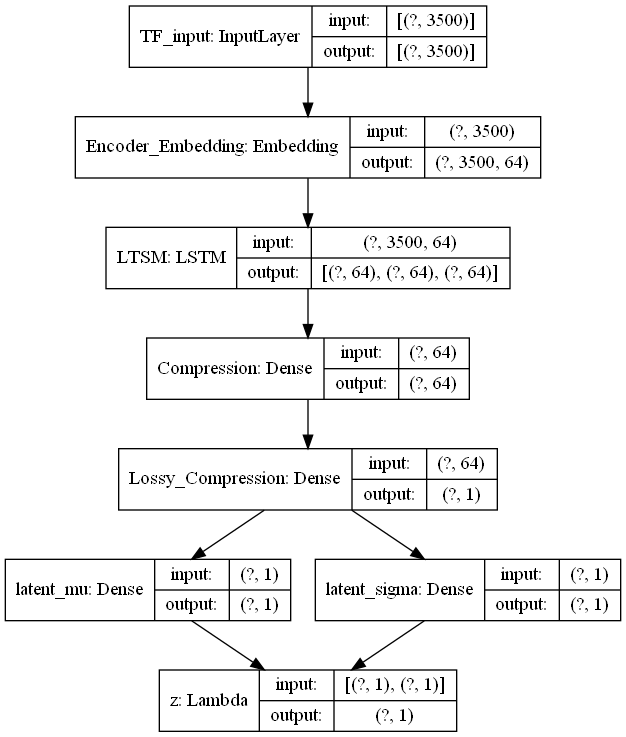

In [44]:
tf.keras.utils.plot_model(text_encoder, show_shapes=True)

## Decoder

In [45]:
decoder_input      = tf.keras.layers.Input(shape=(1, ), dtype='float32', name='decoder_input')
dense_decompress   = tf.keras.layers.Dense(64, dtype='float32', name='input_expanded')(decoder_input)
decoder_embedded   = tf.keras.layers.Embedding(input_dim=64, dtype='float32', output_dim=64, mask_zero=True, name="input_embedded")(decoder_input)
LTSM_layer         = tf.keras.layers.LSTM(64, dtype='float32')(decoder_embedded)
final_output_dense = tf.keras.layers.Dense(MAX_SEQUENCE_LENGHT, dtype='float32')(LTSM_layer)

In [46]:
text_decoder = tf.keras.Model(decoder_input, final_output_dense, name='TextDecoder')
text_decoder.summary()

Model: "TextDecoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 1)]               0         
_________________________________________________________________
input_embedded (Embedding)   (None, 1, 64)             4096      
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 3500)              227500    
Total params: 264,620
Trainable params: 264,620
Non-trainable params: 0
_________________________________________________________________


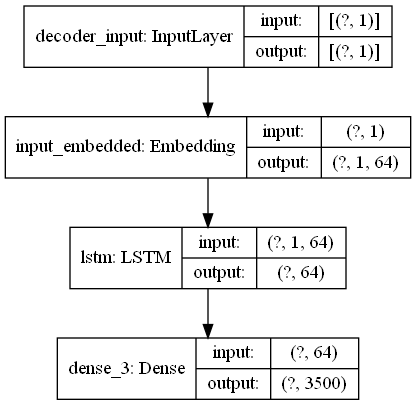

In [47]:
tf.keras.utils.plot_model(text_decoder, show_shapes=True)

# VAE - Tweets

In [48]:
# Instantiate VAE
tweet_vae_outputs  = text_decoder(text_encoder(encoder_input)[2])
tweets_vae         = tf.keras.Model(encoder_input, tweet_vae_outputs, name='Text-VAE')
tweets_vae.summary()

Model: "Text-VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
TF_input (InputLayer)        [(None, 3500)]            0         
_________________________________________________________________
TextCompressionModel (Functi [(None, 1), (None, 1), (N 37573     
_________________________________________________________________
TextDecoder (Functional)     (None, 3500)              264620    
Total params: 302,193
Trainable params: 302,193
Non-trainable params: 0
_________________________________________________________________


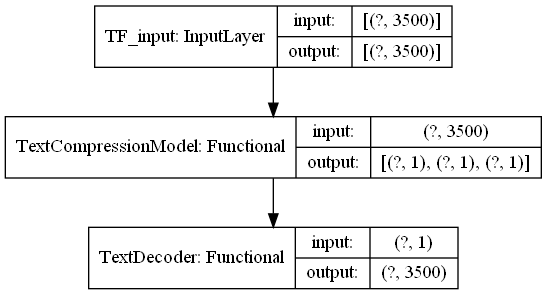

In [49]:
tf.keras.utils.plot_model(tweets_vae, show_shapes=True)

## Loss Function

In [50]:
"""
We are calcuating the binary crossentropy here.
KL Divergence and Reconstruction are the two
metrics which we are using to make prediction.
"""
def tweets_kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * text_input_shape[0]
    # KL divergence loss
    kl_loss = -0.5 * (1 + text_sigma - K.square(text_mu) - K.exp(text_sigma))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    # Total loss = 50% rec + 50% KL divergence loss
    return (reconstruction_loss + kl_loss)

tweets_reconstruction_loss = tf.function(tweets_kl_reconstruction_loss)

tweets_kl_divergence_loss = tf.keras.losses.KLDivergence(reduction="auto", name="kl_divergence")

## Training

In [51]:
"""
We are using the adam optimizer from Keras in combination
of our own defined loss function which is the mean of
reconstruction loss and the KL divergence.
"""
tweets_vae.compile(optimizer="adam", loss=tweets_kl_divergence_loss, run_eagerly=True)

In [52]:
tweets_training_data = np.float32(encoder(tweets_dna).numpy())
#tweets_training_data = np.array(tweets_training_data)

In [53]:
tweets_training_data.shape

(100, 3500)

In [54]:
history = tweets_vae.fit(x = tweets_training_data[0], y=tweets_training_data[0])

AttributeError: 'Tensor' object has no attribute 'numpy'

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
prediction_tweets = tweets_vae.predict(tweet_data)

In [ ]:
"""
This function is being used to print the original tweet
and the predicted tweet string side by side for comparison.
"""
for n in range(1):
    print("Original: ", tweets_dna[n])
    print("Processed: ", " ".join(vocab[abs(np.floor(prediction_tweets)).astype(int)[n]]))
    print()

# ------------------------------------------------------------------------------------------------------------